In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy import constants as const

from astropy.time import Time
from astropy.coordinates import SkyCoord, SkyOffsetFrame, EarthLocation

from astropy.visualization import quantity_support, time_support

In [2]:
quantity_support()
time_support(format='iso')

%matplotlib inline

In [3]:
p_orb_p = 5.7410459 * u.day
asini_p = 3.3667144 * const.c * u.s
i_p = 137.56 * u.deg
omega_p = 207. * u.deg
t_asc_p = Time(54501.4671, format='mjd', scale='tdb')

d_p = 156.79 * u.pc
d_s = 90.6 * u.pc
xi = 134.6 * u.deg
v_lens = -31.9 * u.km / u.s

In [4]:
psr_coord = SkyCoord('04h37m15.99744s -47d15m09.7170s',
                     distance=d_p,
                     pm_ra_cosdec=121.4385 * u.mas / u.yr,
                     pm_dec=-71.4754 * u.mas / u.yr)

In [5]:
k_p = 2.*np.pi * asini_p / p_orb_p

s = 1 - d_s / d_p
d_eff = d_p * d_s / (d_p - d_s)

delta_omega_p = xi - omega_p

In [6]:
t_mjd = np.arange(55000., 55700., 0.25)
t = Time(t_mjd, format='mjd', scale='utc')

In [7]:
lens_frame = SkyOffsetFrame(origin=psr_coord, rotation=xi)

In [8]:
earth_loc = EarthLocation('148°15′47″E', '32°59′52″S')

v_earth = earth_loc.get_gcrs(t).transform_to(lens_frame).velocity.d_z

In [9]:
ph_p = ((t - t_asc_p) / p_orb_p).to(u.dimensionless_unscaled) * u.cycle

v_p_orb = (-k_p / np.sin(i_p)
            * (np.cos(delta_omega_p) * np.sin(ph_p)
             - np.sin(delta_omega_p) * np.cos(i_p) * np.cos(ph_p)))

In [10]:
v_p_sys = psr_coord.transform_to(lens_frame).velocity.d_z

In [11]:
v_eff = 1. / s * v_lens - (1. - s) / s * (v_p_sys + v_p_orb) - v_earth

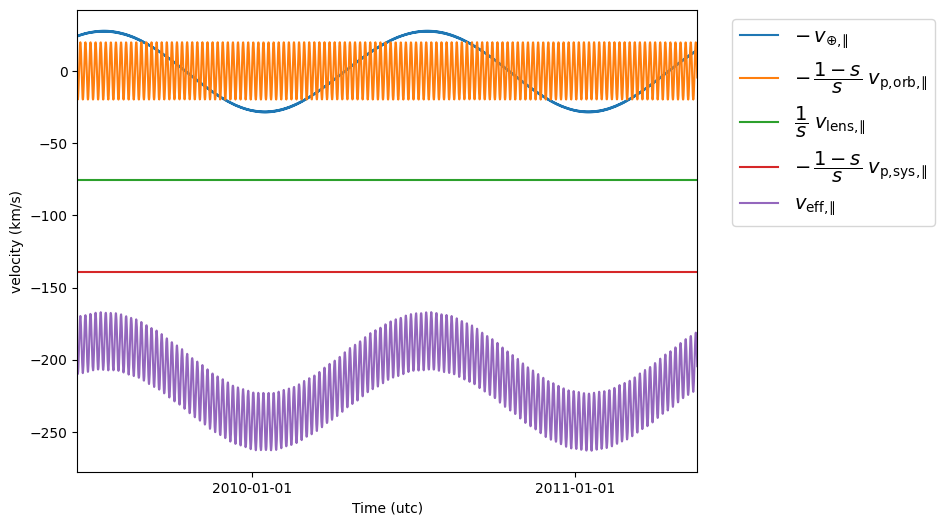

In [12]:
plt.figure(figsize=(8., 6.))

plt.plot(t, - v_earth)
plt.plot(t, - ((1. - s) / s) * v_p_orb)
plt.plot(t[::len(t)-1], 1. / s * v_lens * [1., 1.])
plt.plot(t[::len(t)-1], - ((1. - s) / s) * v_p_sys * [1., 1.])
plt.plot(t, v_eff)
plt.legend([r'$- \, v_{\oplus,\!\!\parallel}$',
            r'$- \, \dfrac{ 1 - s }{ s } \; v_\mathrm{p,\!orb,\!\!\parallel}$',
            r'$\dfrac{ 1 }{ s } \; v_\mathrm{lens,\!\!\parallel}$',
            r'$- \, \dfrac{ 1 - s }{ s } \; v_\mathrm{p,\!sys,\!\!\parallel}$',
            r'$v_\mathrm{eff,\!\!\parallel}$'],
           bbox_to_anchor=(1.04, 1.), loc='upper left', fontsize=14)
plt.xlim(t[0], t[-1])
plt.ylabel(r'velocity (km/s)')

plt.show()

In [13]:
lambda_obs = (1400. * u.MHz).to(u.m, equivalencies=u.spectral())

eta = lambda_obs**2 * d_eff / (2. * const.c * v_eff**2)

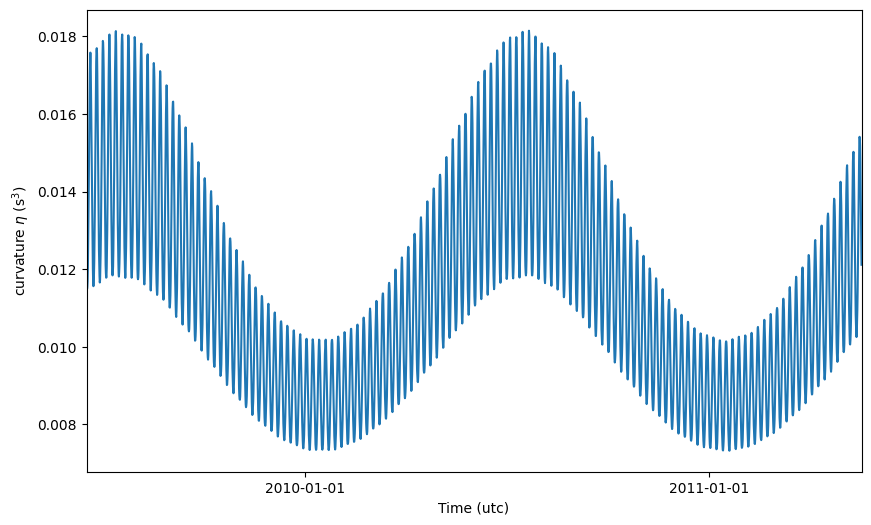

In [14]:
plt.figure(figsize=(10., 6.))

plt.plot(t, eta.to(u.s**3))
plt.xlim(t[0], t[-1])
plt.ylabel(r'curvature $\eta$ (s$^3$)')

plt.show()

In [15]:
dveff = np.abs(v_eff) / np.sqrt(d_eff)

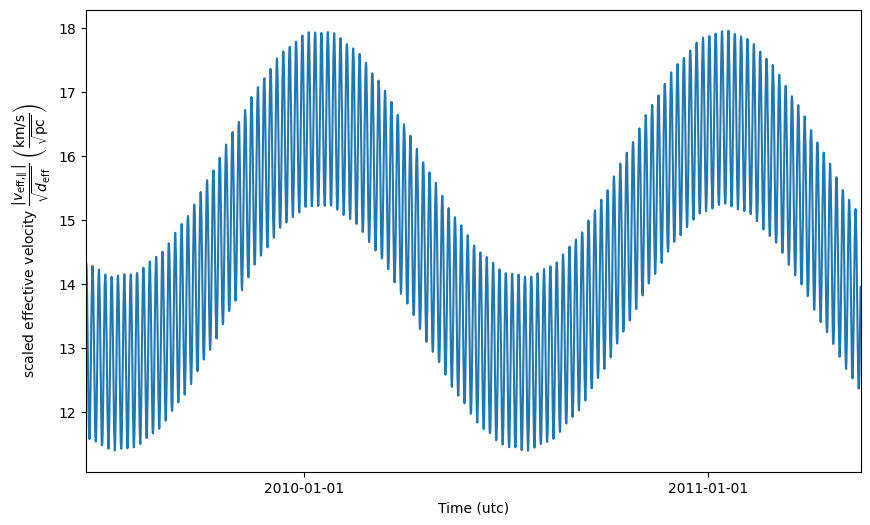

In [16]:
plt.figure(figsize=(10., 6.))

plt.plot(t, dveff)
plt.xlim(t[0], t[-1])
dveff_lbl = (r'scaled effective velocity '
             r'$\dfrac{ | v_\mathrm{eff,\!\!\parallel} | }'
             r'{ \sqrt{ d_\mathrm{eff} } }$ '
             r'$\left( \dfrac{\mathrm{km/s}}{\sqrt{\mathrm{pc}}} \right)$')
plt.ylabel(dveff_lbl)

plt.show()

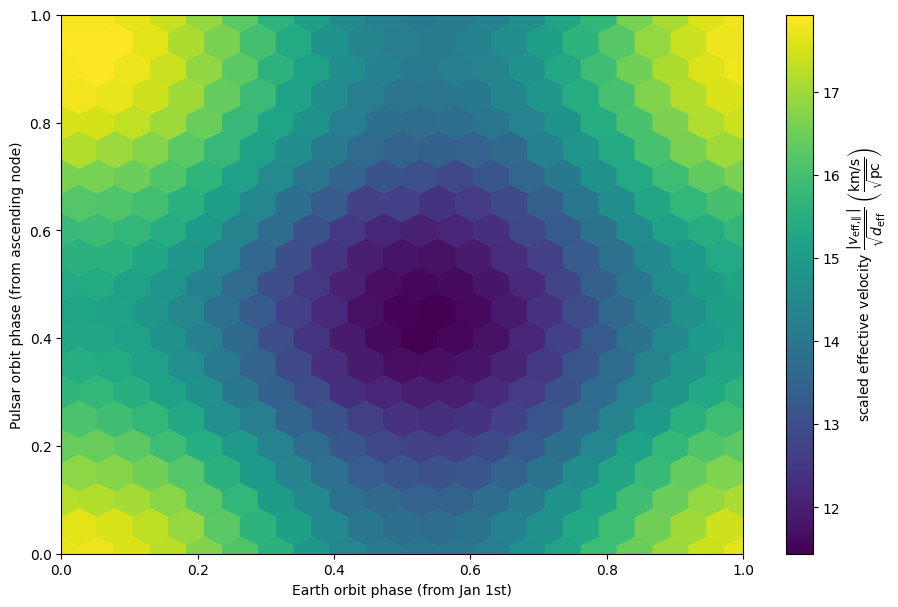

In [17]:
plt.figure(figsize=(11., 7.))

plt.hexbin(t.jyear % 1., ph_p.value % 1., C=dveff.value,
           reduce_C_function=np.median, gridsize=19)
plt.xlim(0., 1.)
plt.ylim(0., 1.)
plt.xlabel('Earth orbit phase (from Jan 1st)')
plt.ylabel('Pulsar orbit phase (from ascending node)')
cbar = plt.colorbar()
cbar.set_label(dveff_lbl)

plt.show()

In [18]:
np.random.seed(654321)
nt = 2645
dt_mean = 16.425 * u.yr / nt
dt = np.random.random(nt) * 2. * dt_mean
t = Time(52618., format='mjd') + dt.cumsum()

In [19]:
v_earth = earth_loc.get_gcrs(t).transform_to(lens_frame).velocity.d_z

ph_p = ((t - t_asc_p) / p_orb_p).to(u.dimensionless_unscaled) * u.cycle

v_p_orb = (-k_p / np.sin(i_p)
            * (np.cos(delta_omega_p) * np.sin(ph_p)
            - np.sin(delta_omega_p) * np.cos(i_p) * np.cos(ph_p)))

v_eff = 1. / s * v_lens - (1. - s) / s * (v_p_orb + v_p_sys) - v_earth

dveff = np.abs(v_eff) / np.sqrt(d_eff)

In [20]:
dveff_err = (np.random.random(nt) * 0.05 + 0.05) * np.mean(dveff)
dveff_obs = dveff + dveff_err * np.random.normal(size=nt)

In [ ]:
np.savez('data/fake-data-J0437.npz',
         t_mjd=t.mjd,
         dveff_obs=dveff_obs.value,
         dveff_err=dveff_err.value)